<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.
<h2>Задача</h2>
<p>Моделирование оттока клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы.</p>
<p> </p>
<p>Перед тем как смотреть на данные, сразу проинициализируем несколько функций:</p>
<ul type="square">
    <li><b>corrmat</b> - визуализирует корреляционную матрицу числовых признаков в датасете</li>
    <li><b>cat_num_split</b> - возвращает списки категориальных (дискретных) и числовых (непрерывных) признаков</li>
    <li><b>plot_features</b> - визуализирует фичи из датасета (<i>violinplot'ы</i> - для числовых и <i>countplot'ы</i> - для категориальных)</li>

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [ ]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [ ]:
data = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')

In [ ]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',#3
    'IsSeniorCitizen',#5
    'HasPartner',#6
    'HasChild',#7
    'HasPhoneService',#8
    'HasMultiplePhoneNumbers',#9
    'HasInternetService',#10
    'HasOnlineSecurityService',#11
    'HasOnlineBackup',#12
    'HasDeviceProtection',#13
    'HasTechSupportAccess',#14
    'HasOnlineTV',#15
    'HasMovieSubscription',#16
    'HasContractPhone',#17
    'IsBillingPaperless',#18
    'PaymentMethod'#19
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

### Обрабатываем обучаемые данные

In [ ]:
data

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0


Посмотрим на общую информацию

In [ ]:
print ('{} ' ' {}', data.dtypes, data.info)

{}  {} ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object <bound method DataFrame.info of       ClientPeriod  MonthlySpending  ...              PaymentMethod Churn
0               55            19.50  ...               Mailed check     0
1               72            25.85  ...    Credit card (automatic)     0
2    

In [ ]:
#делаем преобразование типов с object на float, чтобы nan обозначмились в ьаблице ниже
data["TotalSpent"] = pd.to_numeric(data.TotalSpent, errors='coerce')

In [ ]:
data = data.replace(' ', np.nan)

In [ ]:
#для каждого столбца считаем количество nan: их 9
lst = [data.isna().any().index,data.isna().sum().values]
df = pd.DataFrame(lst)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#заменяем пробелы на NaN и удаляем их

data = data.fillna(np.mean(data['TotalSpent']))

Считаем NaN в каждом столбце

In [ ]:
lst = [data.isna().any().index,data.isna().sum().values]
df = pd.DataFrame(lst)
df
#теперь их 0 в столбце TotalSpent

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8c2f2c750>,
      dtype=object)

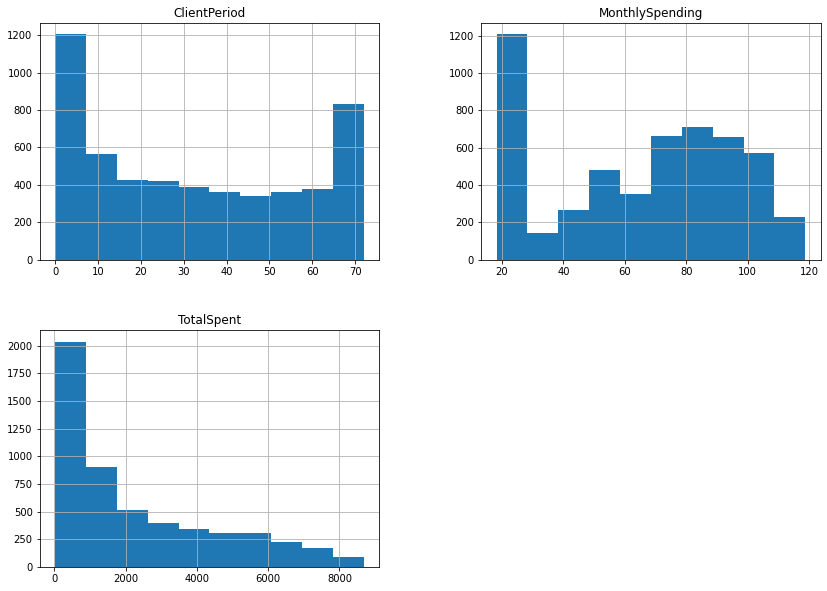

In [ ]:
# Посмотрим на распредление величин
data.hist(column=num_cols, figsize=(14, 10))

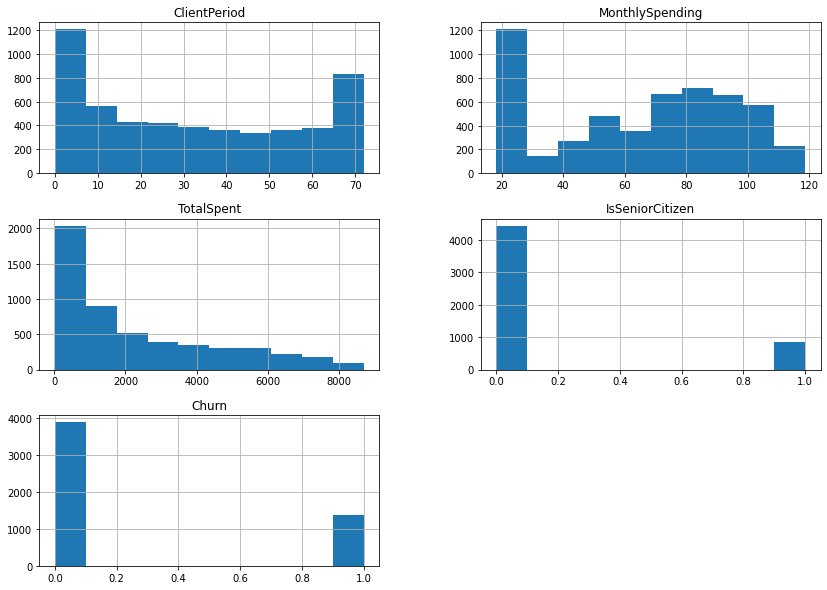

In [ ]:
data.hist(column=num_cols+cat_cols+[target_col], figsize=(14, 10))
None

Сколько данных в каждом солбце числовых признаков (для каждого значения):

In [ ]:
for col in num_cols:
    print(f"{col} DISTRIBUTION")
    print(data[col].value_counts())
    print()

ClientPeriod DISTRIBUTION
1     457
72    284
2     165
3     162
4     136
     ... 
57     39
39     35
36     34
44     34
0       9
Name: ClientPeriod, Length: 73, dtype: int64

MonthlySpending DISTRIBUTION
20.05     46
19.65     35
19.95     34
20.00     33
19.80     32
          ..
51.60      1
52.30      1
114.75     1
58.70      1
39.20      1
Name: MonthlySpending, Length: 1468, dtype: int64

TotalSpent DISTRIBUTION
20.200000      9
2291.390461    9
19.750000      8
19.650000      6
20.050000      6
              ..
990.450000     1
4144.800000    1
116.650000     1
2659.450000    1
150.000000     1
Name: TotalSpent, Length: 4978, dtype: int64



Сколько данных в каждом столбце категориальных признаков  (для каждого значения):

In [ ]:
for col in cat_cols:
    print(f"{col} DISTRIBUTION")
    print(data[col].value_counts())
    print()
for col in num_cols:
    print(f"{col} DISTRIBUTION")
    print(data[col].value_counts())
    print()

Sex DISTRIBUTION
Male      2655
Female    2627
Name: Sex, dtype: int64

IsSeniorCitizen DISTRIBUTION
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64

HasPartner DISTRIBUTION
No     2705
Yes    2577
Name: HasPartner, dtype: int64

HasChild DISTRIBUTION
No     3676
Yes    1606
Name: HasChild, dtype: int64

HasPhoneService DISTRIBUTION
Yes    4761
No      521
Name: HasPhoneService, dtype: int64

HasMultiplePhoneNumbers DISTRIBUTION
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64

HasInternetService DISTRIBUTION
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64

HasOnlineSecurityService DISTRIBUTION
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64

HasOnlineBackup DISTRIBUTION
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dty

В числовом признаке есть проблемы. Нужно их либо убирать (удалять),либо заменять чем-то (средним по столбцу или 0)

In [ ]:
def cat_num_split(data):
    return data.dtypes[data.dtypes == 'object'].keys(), data.dtypes[data.dtypes != 'object'].keys()

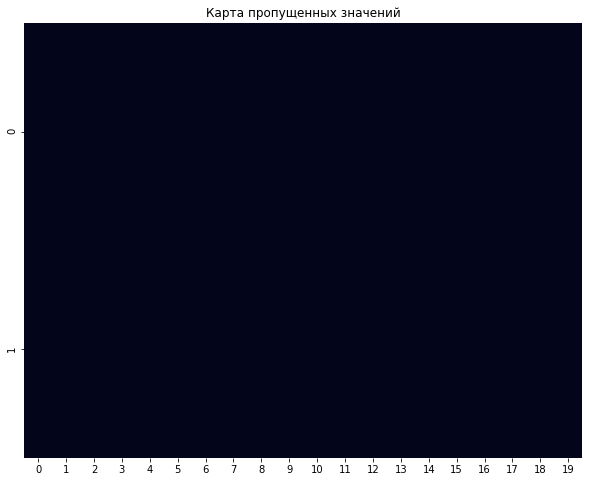


Количество пропусков в каждом столбце:


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
dtype: int64

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.isnull(), cbar=False).set_title('Карта пропущенных значений')
plt.show()

print("\nКоличество пропусков в каждом столбце:")
df.isnull().sum()

Поссмотрим насколько приззнаки зависят друг от друга (через коэф. корреляции)

In [ ]:
data.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
ClientPeriod,1.00,0.25,0.01,-0.35
MonthlySpending,0.25,1.00,0.22,0.18
IsSeniorCitizen,0.01,0.22,1.00,0.16
Churn,-0.35,0.18,0.16,1.00


Еще один способ взглянуть на корреляционную матрицу

In [ ]:
def corrmat(data):
    plt.figure(figsize=(10,10))
    sns.heatmap(data.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}).set_title("Correlation Matrix")
    plt.show()

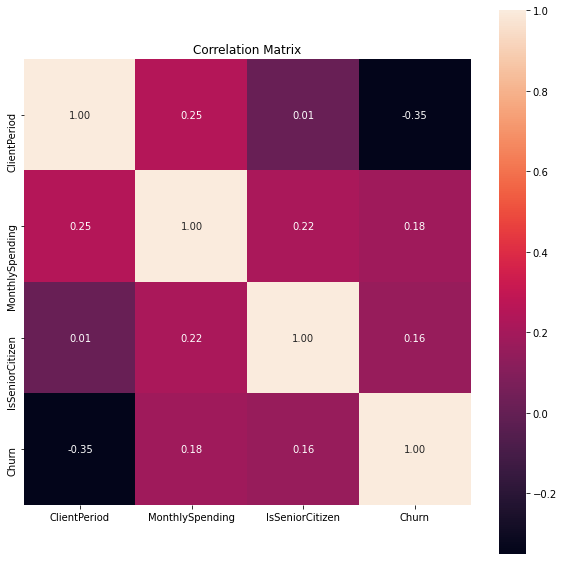

In [ ]:
corrmat(data)

Теперь посмотрим на то, как распределен сам целевой признак - Churn:

Процент нелояльных клиентов: 26.2%


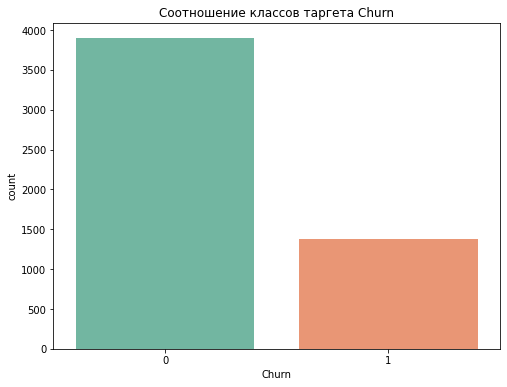

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Churn', palette='Set2').set_title('Соотношение классов таргета Churn')
print(f'Процент нелояльных клиентов: {round(100 * data[data.Churn == 1].shape[0] / data.shape[0], 2)}%')

Явная несбалансированность

Построим boxplots:

In [ ]:
def plot_features(data, categorical=False, bar_colors='muted'):
    
    palette = sns.color_palette('muted')
    
    cat_cols, num_cols = cat_num_split(data)
    
    if categorical:
        _, ax = plt.subplots(4, 4, figsize=(22, 25))

        for i, col in enumerate(cat_cols):
            sns.countplot(data=data, x=col, palette=bar_colors, hue='Churn', ax=ax[i // 4, i % 4]).set_title(f"Соотношение значений в {col}")
            
    else:
        _, ax = plt.subplots(2, 2, figsize=(13, 13))

        for i, col in enumerate(num_cols):
            sns.violinplot(data=data[col], color=palette[i], ax=ax[i // 2, i % 2]).set(title=f"График распределения {col}",
                                                                                    xticklabels=[], xlabel=None)

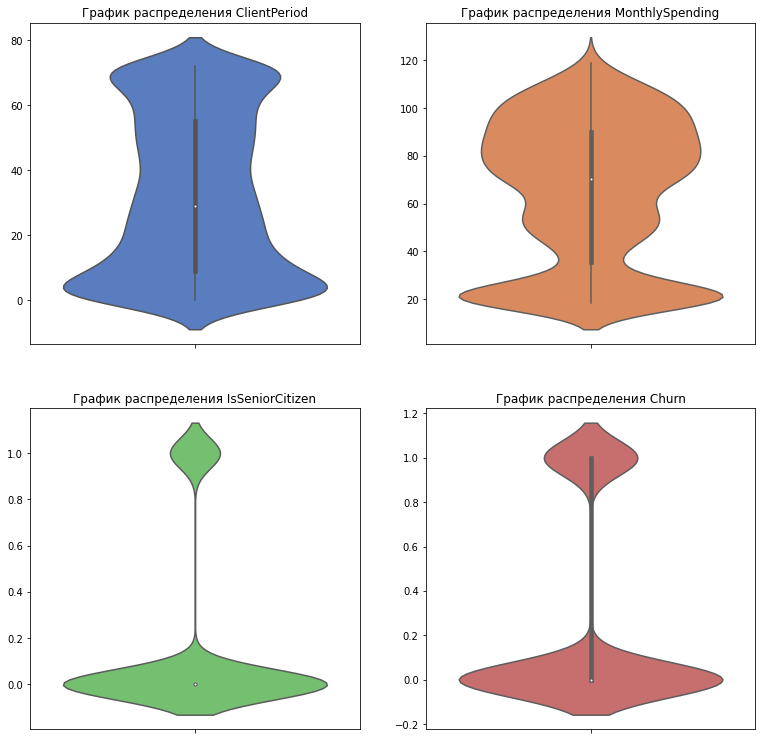

In [ ]:
cat_cols, num_cols = cat_num_split(data)

plot_features(data=data)

Получили распределения для общего случая. Посмотрим, как изменяются распределения этих числовых признаков в зависимости от Churn'a:

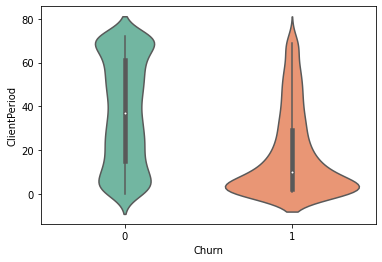

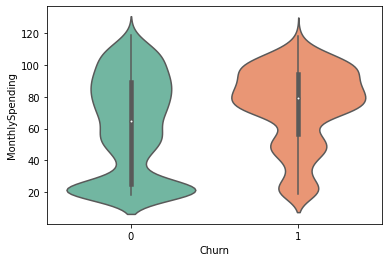

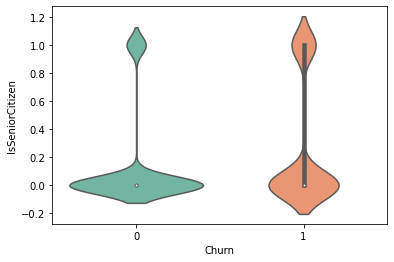

In [ ]:
for num_col in num_cols[:-1]:
    sns.violinplot(data=data, x='Churn', y=f'{num_col}', palette='Set2')
    plt.show()

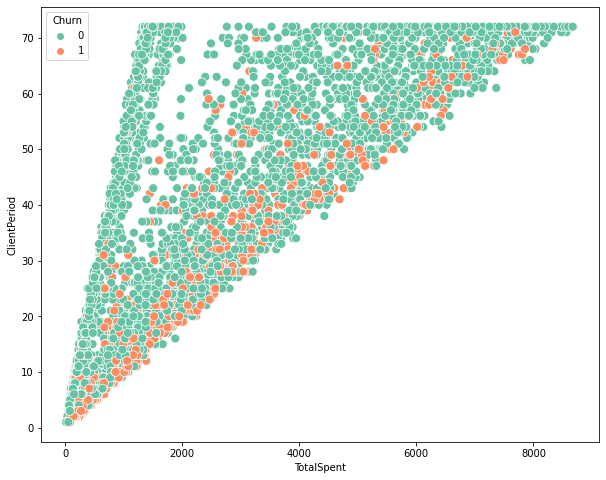

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='TotalSpent', y='ClientPeriod', s=80, hue='Churn', palette='Set2')

<p>Из данного графика разброса, видно, что точки образуют треугольное облако, ограниченное двумя прямыми:</p>
<ul type='circle'>
    <li><b>Левая прямая</b> - сколько человек может потратить минимально за то время, что он является клиентом</li>
    <li><b>Правая прямая</b> - сколько человек может потратить максимально за то время, что он является клиентом</li>
</ul> 
<p>Скопление нелояльных клиентов находится преимущественно в области <b>"правой прямой"</b></p>

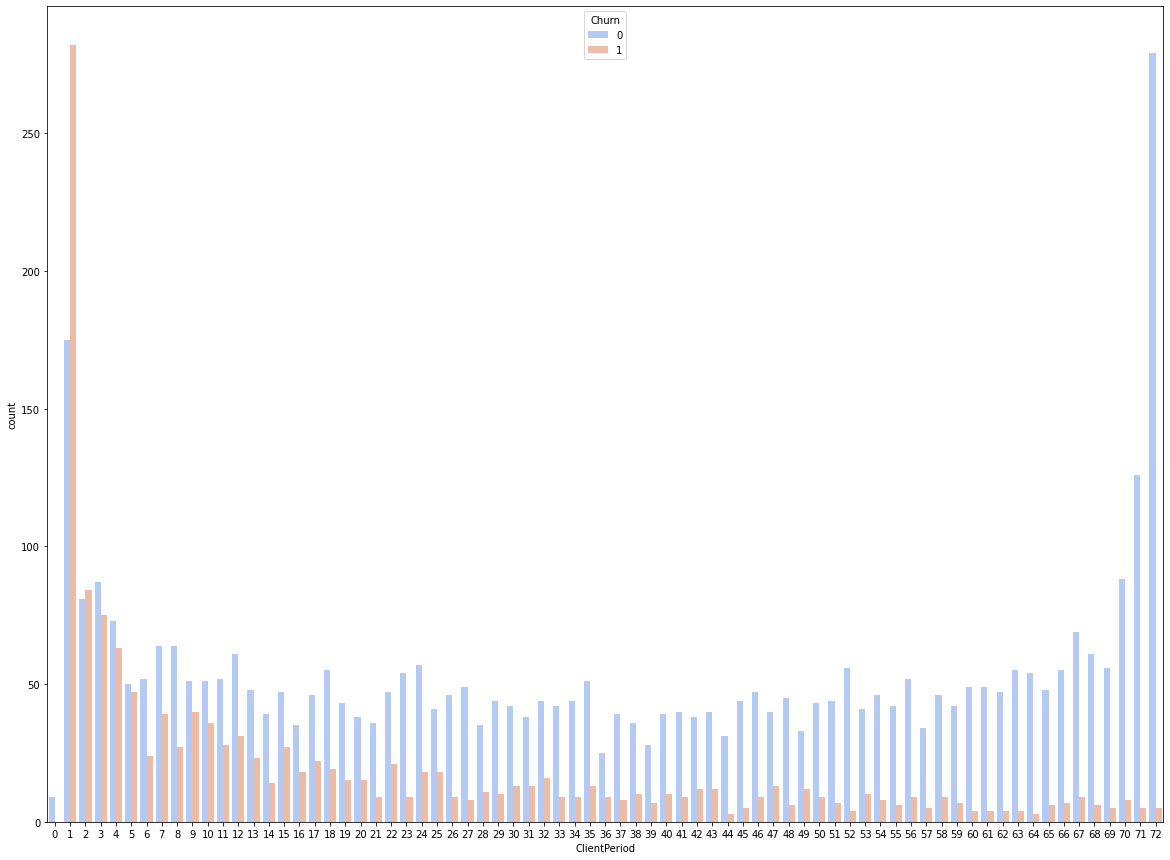

In [ ]:
plt.figure(figsize=(20, 15))
sns.countplot(data=data, x='ClientPeriod', hue='Churn', palette='coolwarm')

Люди, которые отказываются от услуг компании - это преимущественно новички... Возможно, не разобрались с оптимальными тарифами и т.д. Ну а надежные кллиенты, это прежде всего те, кто давно является клиентом компании.

Исследуем категориальные признаки:

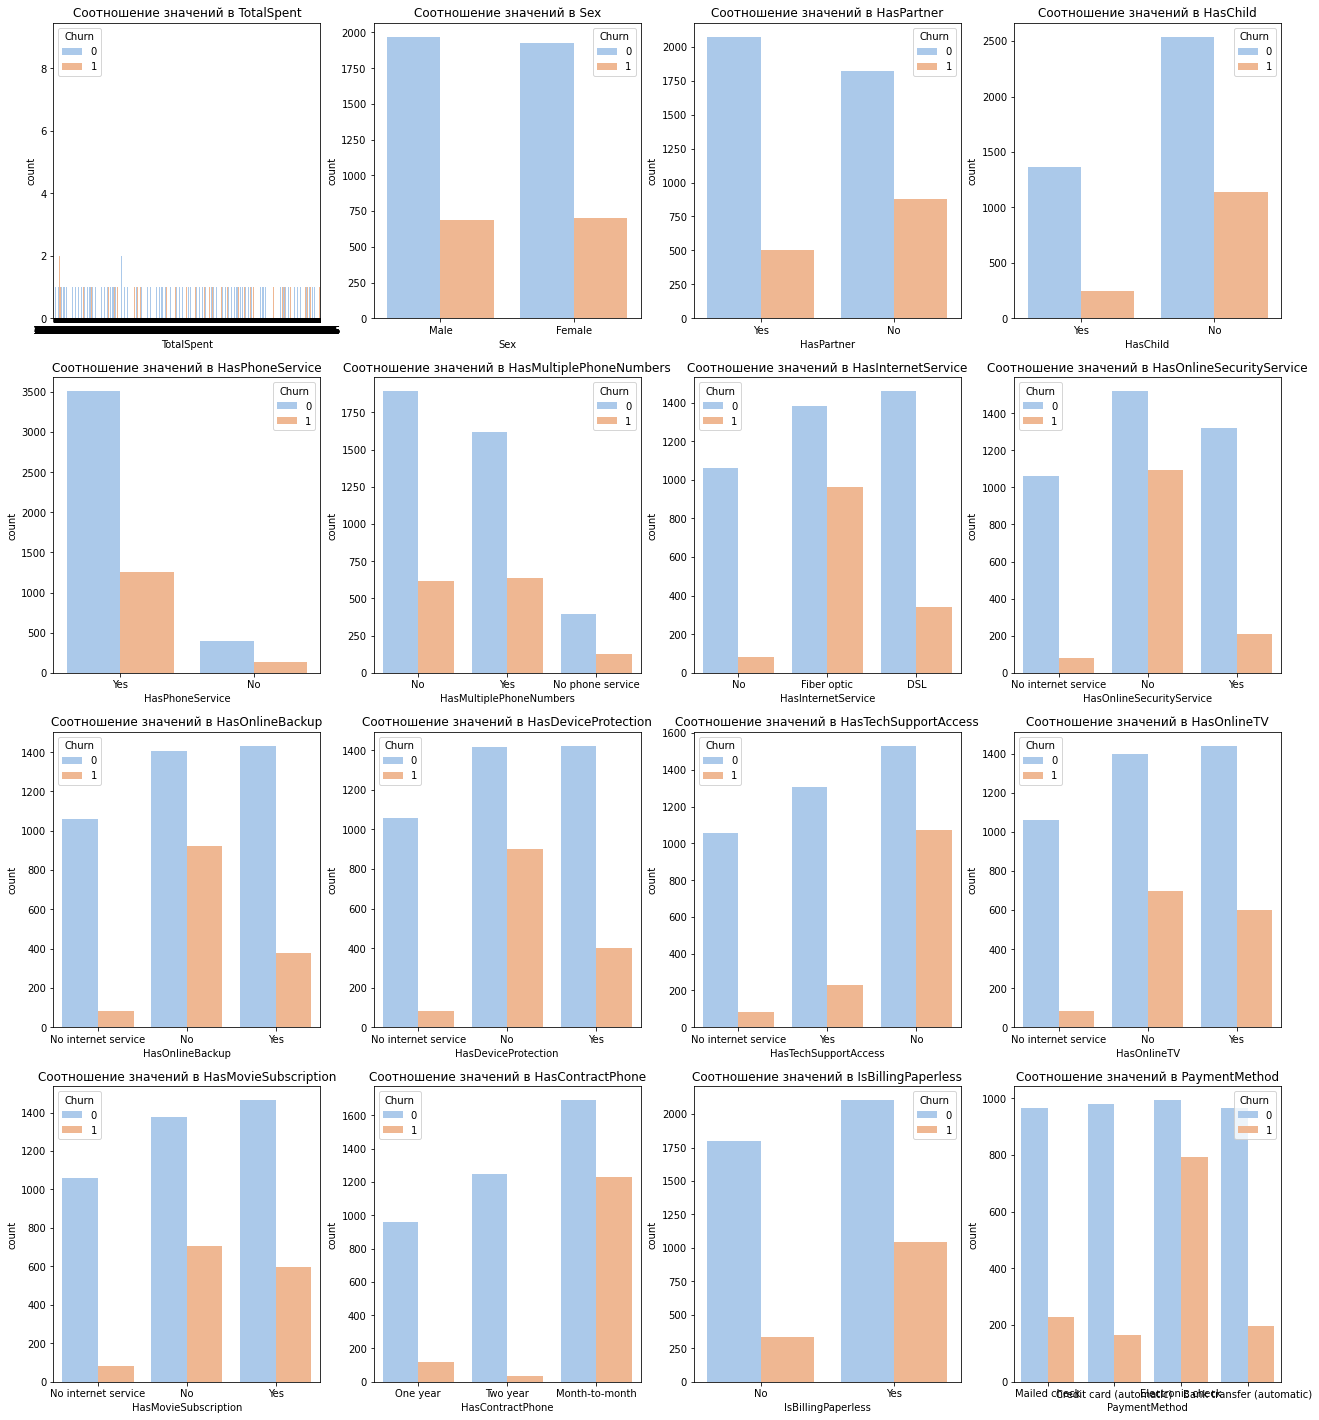

In [ ]:
plot_features(data=data, categorical=True, bar_colors='pastel')

Поскольку есть признак HasPhoneService, который говорит о наличии телефонной связи, сооответственно нет необходимости в значении "No phone service" в признаке HasMultiplePhoneNumbers. "No phone service" можно отнести к значению "No".

Аналогично со значениями "No internet service". В соответствующих признаках данное значение можно отнести к значению "No".

Так как если у нас нет какого-то сервиса, то нет и его производных.

В признаке HasContractPhone значения "One year" и "Two year" можно объединить в одно - "Year-or-more".

В признаке PaymentMethod возможные значения можно разбить на более крупные категории "Automatic" и "Check"

Мужчины и женщины примерно в одинаковой степени являются надежными/ненадежными клиентами. Такой признак вообще можно удалить из датасета, поскольку он не является информативным. Произведем замены и удаления в данных, и посмотрим уже на новые графики.

In [ ]:
data.replace({'One year' : 'Year-or-more', 'Two year' : 'Year-or-more'}, inplace=True)
data.replace({'Electronic check' : 'Check', 'Mailed check' : 'Check', 
            'Bank transfer (automatic)' : 'Automatic', 'Credit card (automatic)' : 'Automatic'}, inplace=True)
data.replace({'No internet service' : 'No'}, inplace=True)
data.replace({'No phone service' : 'No'}, inplace=True)

data.drop(['Sex'], axis=1, inplace=True)
data['IsSeniorCitizen'] = data['IsSeniorCitizen'].astype('object')

KeyError: ignored

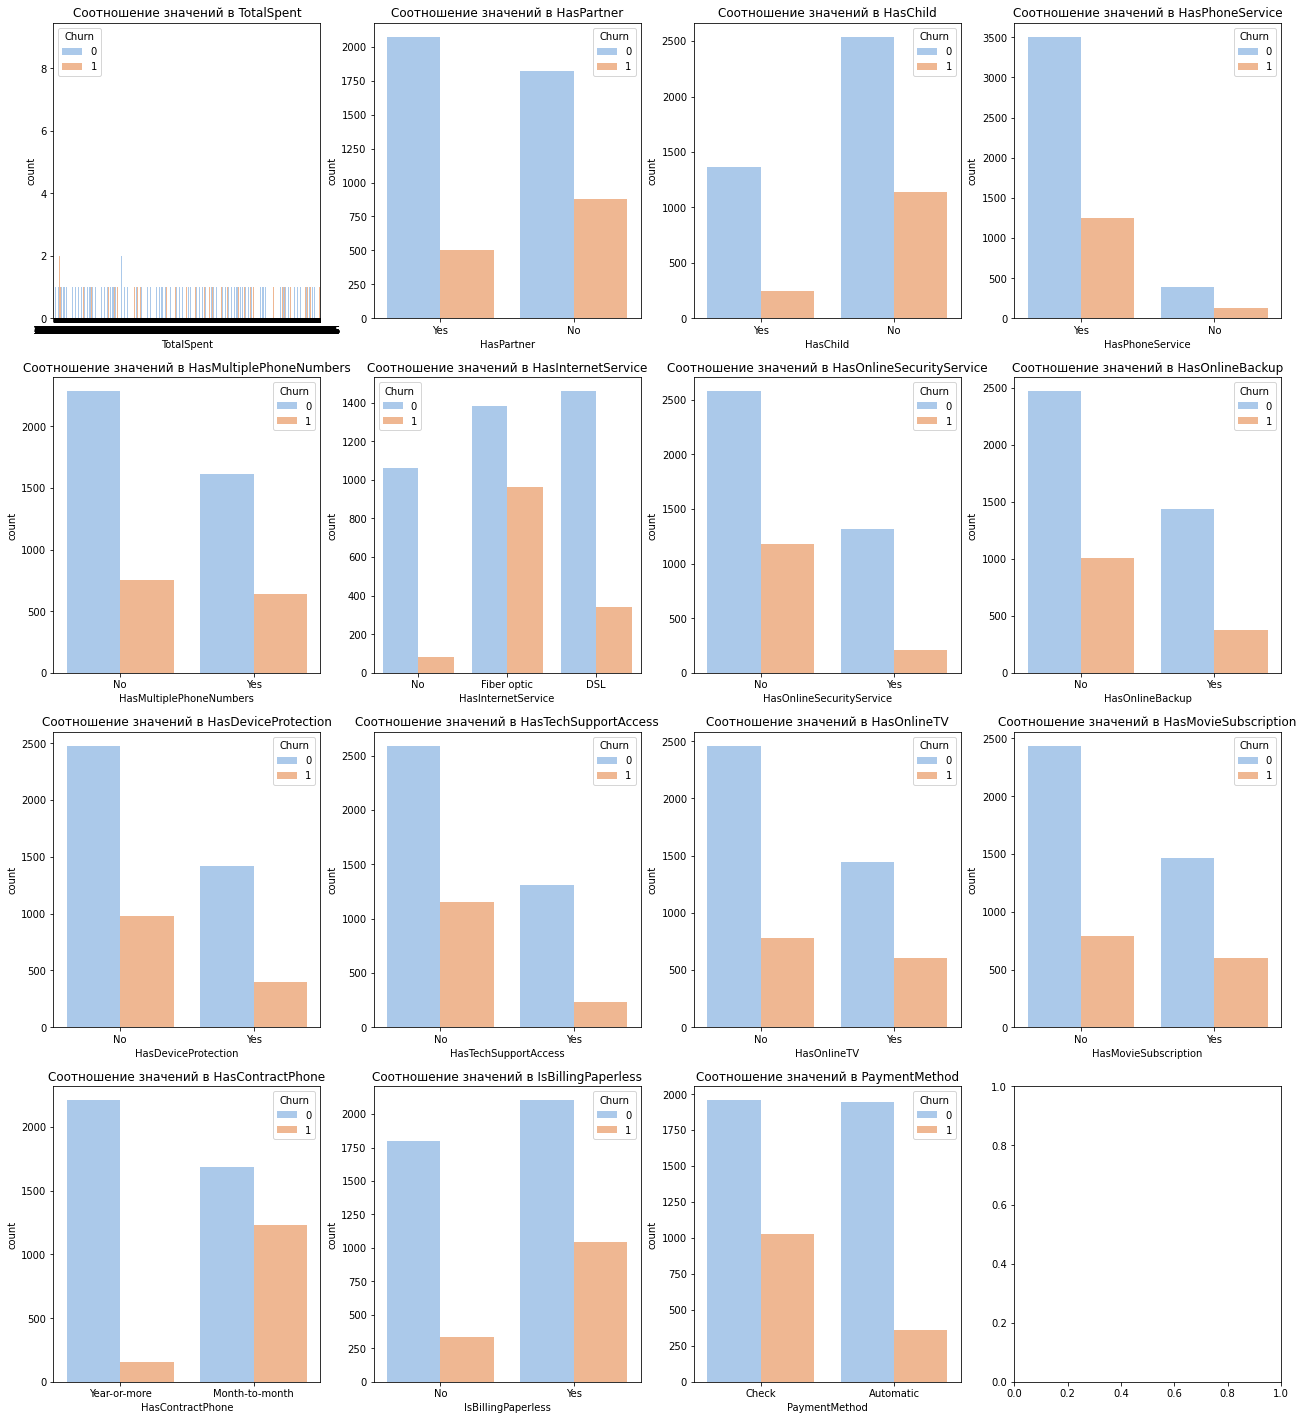

In [ ]:
plot_features(data=data, categorical=True, bar_colors='pastel')

TotalSpent очень сильно скоррелирован с признаками ClientPeriod и MonthlySpending. Преобразуем его.

Добавим новый признак Residual = | TotalSpent - MonthlySpending * ClientPeriod | (То есть заменим TotalSpent на остаток между тем, сколько человек потратил всего денег и сколько он бы потратил, если бы платил каждый месяц столько, сколько платит сейчас)

In [ ]:
data['Residual'] = np.abs(data.TotalSpent - data.ClientPeriod * data.MonthlySpending)


In [ ]:
data.drop(['TotalSpent'], inplace=True, axis=1)
data

,ClientPeriod,MonthlySpending,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn,Residual
0,55,19.50,0,Yes,Yes,Yes,No,No,No,No,No,No,No,No,Year-or-more,No,Check,0,46.15
1,72,25.85,0,Yes,No,Yes,Yes,No,No,No,No,No,No,No,Year-or-more,No,Automatic,0,11.00
2,1,75.90,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Check,1,0.00
3,32,79.30,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Check,0,32.40
4,60,115.25,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Year-or-more,No,Automatic,0,156.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,0,No,No,No,No,DSL,No,No,No,Yes,No,No,Month-to-month,No,Check,0,9.05
5278,50,44.45,0,Yes,No,No,No,DSL,Yes,No,No,Yes,Yes,No,Year-or-more,Yes,Automatic,0,34.05
5279,1,55.05,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Check,0,0.00
5280,29,76.00,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Automatic,0,11.25


Обновим списки столбцов:

In [ ]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'Residual'
]

# Категориальные признаки
cat_cols = [
    'IsSeniorCitizen',#5
    'HasPartner',#6
    'HasChild',#7
    'HasPhoneService',#8
    'HasMultiplePhoneNumbers',#9
    'HasInternetService',#10
    'HasOnlineSecurityService',#11
    'HasOnlineBackup',#12
    'HasDeviceProtection',#13
    'HasTechSupportAccess',#14
    'HasOnlineTV',#15
    'HasMovieSubscription',#16
    'HasContractPhone',#17
    'IsBillingPaperless',#18
    'PaymentMethod'#19
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
%matplotlib inline

In [ ]:
c = data['Churn']
data['Churn'] = data['Residual']
data['Residual']= c


In [ ]:
data.rename(columns = {'Churn':'Residual1'}, inplace = True)
data.rename(columns = {'Residual':'Churn'}, inplace = True)
data.rename(columns = {'Residual1':'Residual'}, inplace = True)

Делим на тренировочные и тестовые данные нашу выборку

In [ ]:
X_train, X_test = np.split(data.iloc[:, :], [int(.85*len(data.iloc[:, :-1]))])
y_train,y_test = np.split(data['Churn'], [int(.85*len(data['Churn']))])
scaler = StandardScaler()

Проверим размерность

In [ ]:
print('train shape: {}, {}; test_shape: {}, {}'.format( X_train.shape, y_train.shape, X_test.shape, y_test.shape))

train shape: (4489, 19), (4489,); test_shape: (793, 19), (793,)


In [ ]:
from sklearn.model_selection import StratifiedKFold
#Стратифицированный K-образный кросс-валидатор
strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
num_trans = StandardScaler()
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
cat_trans = OneHotEncoder(sparse=False)
#ссылаемся на списки числовых признаков столбцов и категориальных
new_num_cols = num_cols
new_cat_cols=cat_cols
#задаем парамеры С
C=[100, 10, 1, 0.1, 0.01, 0.001]
penalty= ['l1', 'l2', 'elasticnet', 'none']
solver= ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
#формируем логистическую регрессию
clf_logress_pipe = LogisticRegressionCV(cv=strat, random_state=40, Cs=C, max_iter=10000, scoring='roc_auc', class_weight='balanced', refit=True)
#шаг Pipeline для предподготовки данных: нормализация для числовых признаков и для категориальных признаков преобразования их в числовые
#num_trans - ссылается на метод для нормирования числовых признаков
#cat_trans - ссылается на обработку категориальных признаков OneHotEncoder(sparse=False)
preprocessor = ColumnTransformer(transformers = [
                                                 ('num', num_trans, new_num_cols),
                                                  ('cat', cat_trans, new_cat_cols)
])
#Формируем пайплайн для предподготоки и обучения/тестирования модели
clf_pipe = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', clf_logress_pipe)])


In [ ]:
X_train

,ClientPeriod,MonthlySpending,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Residual,Churn
0,55,19.50,0,Yes,Yes,Yes,No,No,No,No,No,No,No,No,Year-or-more,No,Check,46.15,0
1,72,25.85,0,Yes,No,Yes,Yes,No,No,No,No,No,No,No,Year-or-more,No,Automatic,11.00,0
2,1,75.90,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Check,0.00,1
3,32,79.30,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Check,32.40,0
4,60,115.25,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Year-or-more,No,Automatic,156.55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4484,54,20.00,0,No,No,Yes,No,No,No,No,No,No,No,No,Year-or-more,No,Check,69.65,0
4485,12,54.30,0,No,No,Yes,No,DSL,No,Yes,No,Yes,No,No,Month-to-month,Yes,Check,2.90,0
4486,4,56.75,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Check,18.15,0
4487,41,99.80,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Check,167.50,1


In [ ]:
clf_pipe.fit(X_train, y_train)

ValueError: ignored

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [ ]:
from sklearn.model_selection import cross_val_score
#обучение кросс-валидацией
cv_scores = cross_val_score(clf_pipe, X_train, y_train)
print(cv_scores)
#find best parameters
index, max_value = max(enumerate(cv_scores), key=lambda i_v: i_v[1])
print('Logistic Regression parameters C: ',C[index])
# result:

[0.85876841 0.83916757 0.84042874 0.83506948 0.85102036]
Logistic Regression parameters C:  100


## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
#задаем модель CatBoost
gb_gs = CatBoostClassifier(random_state=1, cat_features=cat_cols, thread_count=3,l2_leaf_reg = 4.0)

#значения для перебирания во время поиска наилучшего параметра для модели
search_n_estimators = range(1, 20)
search_learning_rate = [1, 0.1, 0.01, 0.001, 0.075]

#параметры, которые перебираем при поиске наилучшего параметра для модели
param_grid={'n_estimators': search_n_estimators, 'learning_rate': search_learning_rate}

#формируем GridSearchCV
grid_SearchCV = GridSearchCV(gb_gs, param_grid=param_grid, scoring='roc_auc', return_train_score=True, cv=strat, refit=True)

#обучаем
grid_SearchCV.fit(X_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
1:	learn: 0.6858719	total: 13.6ms	remaining: 68ms
2:	learn: 0.6822730	total: 18.8ms	remaining: 56.4ms
3:	learn: 0.6787611	total: 23.8ms	remaining: 47.7ms
4:	learn: 0.6754078	total: 29.4ms	remaining: 41.2ms
5:	learn: 0.6720293	total: 34.5ms	remaining: 34.5ms
6:	learn: 0.6689280	total: 39.6ms	remaining: 28.3ms
7:	learn: 0.6655466	total: 44.6ms	remaining: 22.3ms
8:	learn: 0.6623516	total: 49.7ms	remaining: 16.6ms
9:	learn: 0.6590238	total: 54.8ms	remaining: 10.9ms
10:	learn: 0.6558582	total: 60.1ms	remaining: 5.46ms
11:	learn: 0.6531278	total: 65.2ms	remaining: 0us
0:	learn: 0.6893423	total: 5.76ms	remaining: 63.4ms
1:	learn: 0.6857097	total: 11.6ms	remaining: 57.9ms
2:	learn: 0.6820700	total: 16.9ms	remaining: 50.8ms
3:	learn: 0.6785027	total: 22.6ms	remaining: 45.1ms
4:	learn: 0.6751171	total: 28.2ms	remaining: 39.5ms
5:	learn: 0.6717480	total: 33.3ms	remaining: 33.3ms
6:	learn: 0.6684197	total: 38.6ms	remaining: 27.6ms

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f59e88b1ed0>,
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [1, 0.1, 0.01, 0.001, 0.075],
                         'n_estimators': range(1, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

Лучшие параметры

In [ ]:
print('Resulting best params:', grid_SearchCV.best_params_)

Resulting best params: {'learning_rate': 1, 'n_estimators': 9}


Результат обучения:

In [ ]:
lst = pd.DataFrame(grid_SearchCV.cv_results_, columns=['mean_test_score', 'params'])
res=np.max(lst['mean_test_score'])
print('Resulting:', res)

Resulting: 0.8386299447551574


Результат тестирования

In [ ]:

print('Resulting score:', grid_SearchCV.score(X_test, y_test))

Resulting score: 0.8265230734257785


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [ ]:
cv_scores = cross_val_score(estimator=grid_SearchCV, X=X_train, y=y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
2:	learn: 0.6827783	total: 14.5ms	remaining: 43.6ms
3:	learn: 0.6793670	total: 19ms	remaining: 38ms
4:	learn: 0.6759005	total: 23.4ms	remaining: 32.8ms
5:	learn: 0.6726977	total: 27.9ms	remaining: 27.9ms
6:	learn: 0.6692276	total: 32.4ms	remaining: 23.1ms
7:	learn: 0.6661442	total: 36.9ms	remaining: 18.4ms
8:	learn: 0.6629229	total: 41.6ms	remaining: 13.9ms
9:	learn: 0.6598803	total: 46ms	remaining: 9.19ms
10:	learn: 0.6568894	total: 50.9ms	remaining: 4.62ms
11:	learn: 0.6538549	total: 55.6ms	remaining: 0us
0:	learn: 0.6896069	total: 5.01ms	remaining: 55.1ms
1:	learn: 0.6859627	total: 10ms	remaining: 50.1ms
2:	learn: 0.6826449	total: 14.3ms	remaining: 42.9ms
3:	learn: 0.6791485	total: 18.8ms	remaining: 37.6ms
4:	learn: 0.6757098	total: 23.6ms	remaining: 33ms
5:	learn: 0.6724812	total: 28.5ms	remaining: 28.5ms
6:	learn: 0.6690023	total: 33.4ms	remaining: 23.8ms
7:	learn: 0.6659275	total: 38ms	remaining: 19ms
8:	learn: 0

Результаты

In [ ]:
cv_scores

array([0.85616764, 0.84012342, 0.84319402, 0.82643892, 0.84302618])

Результаты: лучший результат


In [ ]:
index, max_value = max(enumerate(cv_scores), key=lambda i_v: i_v[1])
cv_scores[index]

0.8431965039645762

### Попробовала с GradientBoostingClassifier
param_grid использовала с предыдущей модели

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
grid_SearchCV2 = GridSearchCV(GradientBoostingClassifier(random_state=42),
                             param_grid=param_grid, scoring='roc_auc', return_train_score=True, n_jobs=-1, cv=strat)


Сделала предобработку данных для обучения

In [ ]:
dummy_features = pd.get_dummies(cat_cols)

In [ ]:
data1 = pd.get_dummies(data, columns=cat_cols)
X_train, X_test = np.split(data1.iloc[:, :-1], [int(.85*len(data1.iloc[:, :-1]))])
y_train, y_test = np.split(data['Churn'], [int(.85*len(data['Churn']))])


Обучаем

In [ ]:
grid_SearchCV2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  m...0,
                                                  n_estimators=100,
                                  

Результаты: лучшие параметры

In [ ]:
print('Resulting best params:', grid_SearchCV2.best_params_)

Resulting best params: {'learning_rate': 1, 'n_estimators': 1}


Лучший результат на тестовых данных:

In [ ]:
lst = pd.DataFrame(grid_SearchCV2.cv_results_, columns=['mean_test_score', 'params'])
res=np.max(lst['mean_test_score'])
print('Resulting:', res)

Resulting: 1.0


In [ ]:
print('Resulting score:', grid_SearchCV2.score(X_test, y_test))

Resulting score: 1.0


# Предсказания

Выбираем лучшую модель:

In [ ]:
best_model=clf_pipe #grid_SearchCV

Читаем данные .csv и сохраняю в X_test

In [ ]:
X_test = pd.read_csv('test.csv')


Чтобы не было ошибки фиксируем в каком порядке были столбцы при тренинге

In [ ]:
cols = list(data.columns.values)
cols

['ClientPeriod',
 'MonthlySpending',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod',
 'Churn',
 'Residual']

Переставляем местами столбцы, чтобы порядок в тренировосном совпадали с тестовой выборке

In [ ]:
X_test=X_test.reindex(columns=cols)
#заменяем пробелы на nan и заменяем их на 0
X_test = X_test.replace(' ', np.nan)
X_test = X_test.fillna(0)
#для нормирования числовых признаков
sc = StandardScaler()
sc.fit(X_test[num_cols])
X_tst_scaled= sc.transform(X_test[num_cols])
X_test[num_cols] = X_tst_scaled
#для обработки категориальных признаков
#X_test_dummies = pd.get_dummies(X_test)

NameError: ignored

Добавим преобразования для тестового набора данных те же,что и для тренировочного

In [ ]:
X_test.replace({'One year' : 'Year-or-more', 'Two year' : 'Year-or-more'}, inplace=True)
X_test.replace({'Electronic check' : 'Check', 'Mailed check' : 'Check', 
            'Bank transfer (automatic)' : 'Automatic', 'Credit card (automatic)' : 'Automatic'}, inplace=True)
X_test.replace({'No internet service' : 'No'}, inplace=True)
X_test.replace({'No phone service' : 'No'}, inplace=True)

X_test.drop(['Sex'], axis=1, inplace=True)

X_test['IsSeniorCitizen'] = X_test['IsSeniorCitizen'].astype('object')

X_test['Residual'] = np.abs(X_test.TotalSpent - X_test.ClientPeriod * X_test.MonthlySpending)
X_test.drop(['TotalSpent'], inplace=True, axis=1)

NameError: ignored

In [ ]:
#читаем файл submission.csv и сохраняем submission
submission = pd.read_csv('./submission.csv')
#получаем предсказание и сохраняем в колонке submission
submission['Churn'] =  best_model.predict_proba(X_test)[:, 1]
#сохраняем файл в csv
submission.to_csv('./my_submission.csv', index=False)

/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Считаем NaN в каждом столбце